In [1]:
#!/usr/bin/env python

import functools
import os.path
import random
import sys
import xml.etree.ElementTree
import numpy as np
import matplotlib.pyplot as plt
import skimage.data
import cv2
import PIL.Image

In [2]:
%matplotlib inline

In [34]:
def load_occluders(pascal_voc_root_path):
    occluders = []
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
    
    annotation_paths = list_filepaths(os.path.join(pascal_voc_root_path, 'Annotations'))
    for annotation_path in annotation_paths:
        xml_root = xml.etree.ElementTree.parse(annotation_path).getroot()
        is_segmented = (xml_root.find('segmented').text != '0')

        if not is_segmented:
            continue

        boxes = []
        for i_obj, obj in enumerate(xml_root.findall('object')):
            is_person = (obj.find('name').text == 'person')
            is_difficult = (obj.find('difficult').text != '0')
            is_truncated = (obj.find('truncated').text != '0')
            if not is_person and not is_difficult and not is_truncated:
                bndbox = obj.find('bndbox')
                box = [int(bndbox.find(s).text) for s in ['xmin', 'ymin', 'xmax', 'ymax']]
                boxes.append((i_obj, box))

        if not boxes:
            continue

        im_filename = xml_root.find('filename').text
        seg_filename = im_filename.replace('jpg', 'png')

        im_path = os.path.join(pascal_voc_root_path, 'JPEGImages', im_filename)
        seg_path = os.path.join(pascal_voc_root_path,'SegmentationObject', seg_filename)

        im = np.asarray(PIL.Image.open(im_path))
        labels = np.asarray(PIL.Image.open(seg_path))

        for i_obj, (xmin, ymin, xmax, ymax) in boxes:
            object_mask = (labels[ymin:ymax, xmin:xmax] == i_obj + 1).astype(np.uint8)*255
            object_image = im[ymin:ymax, xmin:xmax]
            if cv2.countNonZero(object_mask) < 500:
                # Ignore small objects
                continue

            # Reduce the opacity of the mask along the border for smoother blending
            eroded = cv2.erode(object_mask, structuring_element)
            object_mask[eroded < object_mask] = 192
            object_with_mask = np.concatenate([object_image, object_mask[..., np.newaxis]], axis=-1)
            
            # Downscale for efficiency
            object_with_mask = resize_by_factor(object_with_mask, 0.5)
            occluders.append(object_with_mask)

    return occluders

In [33]:
def occlude_with_objects(im, occluders, annotation = None):
    """Returns an augmented version of `im`, containing some occluders from the Pascal VOC dataset."""

    result = im.copy()
    width_height = np.asarray([im.shape[1], im.shape[0]])
    im_scale_factor = min(width_height) / 600
    count = np.random.randint(5, 10)

    for _ in range(count):
        occluder = random.choice(occluders)

        random_scale_factor = np.random.uniform(0.2, 1.0)
        scale_factor = random_scale_factor * im_scale_factor
        occluder = resize_by_factor(occluder, scale_factor)

        center = np.random.uniform([0,0], width_height)
        if(annotation is not None and len(annotation) != 0):
            center = change_center(center, width_height, annotation)
        paste_over(im_src=occluder, im_dst=result, center=center)

    return result

In [5]:
def change_center(center, width_height, annotation):
    """if the occluder block the gt, change the center, max change step is 10"""
    # center: 
    new_center = center
    tick = 10
    for anno in annotation:
        if(tick <= 0):
            break
        x1, y1 ,x2, y2 = anno
        w, h = new_center
        if(w>x1 and w<x2 and h>y1 and h<y2):
            if(w * h < width_height[0] * width_height[1] / 4):
                new_center = np.random.uniform(new_center, width_height)
            else:
                new_center = np.random.uniform([0, 0], new_center)
            tick -= 1
            
    return new_center

In [6]:
def paste_over(im_src, im_dst, center):
    """Pastes `im_src` onto `im_dst` at a specified position, with alpha blending, in place.
    Locations outside the bounds of `im_dst` are handled as expected (only a part or none of
    `im_src` becomes visible).
    Args:
        im_src: The RGBA image to be pasted onto `im_dst`. Its size can be arbitrary.
        im_dst: The target image.
        alpha: A float (0.0-1.0) array of the same size as `im_src` controlling the alpha blending
            at each pixel. Large values mean more visibility for `im_src`.
        center: coordinates in `im_dst` where the center of `im_src` should be placed.
    """

    width_height_src = np.asarray([im_src.shape[1], im_src.shape[0]])
    width_height_dst = np.asarray([im_dst.shape[1], im_dst.shape[0]])

    center = np.round(center).astype(np.int32)
    raw_start_dst = center - width_height_src // 2
    raw_end_dst = raw_start_dst + width_height_src

    start_dst = np.clip(raw_start_dst, 0, width_height_dst)
    end_dst = np.clip(raw_end_dst, 0, width_height_dst)
    region_dst = im_dst[start_dst[1]:end_dst[1], start_dst[0]:end_dst[0]]

    start_src = start_dst - raw_start_dst
    end_src = width_height_src + (end_dst - raw_end_dst)
    region_src = im_src[start_src[1]:end_src[1], start_src[0]:end_src[0]]
    color_src = region_src[..., 0:3]
    alpha = region_src[..., 3:].astype(np.float32)/255

    im_dst[start_dst[1]:end_dst[1], start_dst[0]:end_dst[0]] = (
            alpha * color_src + (1 - alpha) * region_dst)

In [7]:
def resize_by_factor(im, factor):
    """Returns a copy of `im` resized by `factor`, using bilinear interp for up and area interp
    for downscaling.
    """
    new_size = tuple(np.round(np.array([im.shape[1], im.shape[0]]) * factor).astype(int))
    interp = cv2.INTER_LINEAR if factor > 1.0 else cv2.INTER_AREA
    return cv2.resize(im, new_size, fx=factor, fy=factor, interpolation=interp)


In [8]:
def list_filepaths(dirpath):
    names = os.listdir(dirpath)
    paths = [os.path.join(dirpath, name) for name in names]
    return sorted(filter(os.path.isfile, paths))

In [9]:
def main():
    """Demo of how to use the code"""
    
    path = '/data/dataset/VOCtrainval_11-May-2012/VOCdevkit/VOC2012'
    #path = sys.argv[1]

    print('Loading occluders from Pascal VOC dataset...')
    occluders = load_occluders(pascal_voc_root_path=path)
    print('Found {} suitable objects'.format(len(occluders)))

    original_im = cv2.resize(skimage.data.astronaut(), (256,256))
    fig, axarr = plt.subplots(3,3, figsize=(7,7))
    for ax in axarr.ravel():
        occluded_im = occlude_with_objects(original_im, occluders)
        ax.imshow(occluded_im, interpolation="none")
        ax.axis('off')

    fig.tight_layout(h_pad=0)
    # plt.savefig('examples.jpg', dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
# draw gt
def draw_gt(img, annos):
    for anno in annos:
        cv2.rectangle(img, (int(anno[0]), int(anno[1])), (int(anno[2]), int(anno[3])), (0, 255, 0), 2)

In [35]:
# save occluders as .npy
path = '/data/dataset/VOCtrainval_11-May-2012/VOCdevkit/VOC2012'
occluders = load_occluders(pascal_voc_root_path=path)
np.save("VOC_occluders.npy", occluders)

In [11]:
# load occluders
occluders = np.load("VOC_occluders.npy")
print('Found {} suitable objects'.format(len(occluders)))

Found 2638 suitable objects


In [12]:
# read annotation
def read_sur_anno():
    from collections import defaultdict
    train_bbox_path = "/data/dataset/widerped2019/Annotations/train_bbox.txt" 
    security = defaultdict(list)
    with open(train_bbox_path) as file:
        for line in file:
            if(line.startswith("sur")):
                anno = line.strip().split(" ")
                filename = anno[0]
                anno.pop(0)
                results=[]
                if(len(anno) > 0):
                    for i in range(0, len(anno), 4):
                        x, y, w, h = anno[i:i+4]
                        x, y, w, h = int(x), int(y), int(w), int(h)
                        x1 = x 
                        x2 = x + w
                        y1 = y 
                        y2 = y + h
                        results.append([x1, y1, x2, y2])
                security[filename] = results
    return security

In [14]:
# gen occlusion and save img
root_dir = "/data/dataset/widerped2019"
sur_pic_dir = os.path.join(root_dir, "sur_train/sur_train")
output_dir = "/data/dataset/widerped2019_occlusion/sur_train/"

for k,v in security.items():
    img_path = os.path.join(sur_pic_dir, k)
    print(img_path)
    output_path = os.path.join(output_dir, k)
    original_im = cv2.imread(img_path)
    #if(original_im is not None):
    if(True):
        #original_im= cv2.cvtColor(original_im,cv2.COLOR_BGR2RGB)
        original_im= original_im[:,:,::-1]
        img = occlude_with_objects(original_im, occluders, v)
        img = img[:,:,::-1]
        cv2.imwrite(output_path, img, [int(cv2.IMWRITE_JPEG_QUALITY),100])

/data/dataset/widerped2019/sur_train/sur_train/sur06705.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur02549.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur00714.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur03023.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur08426.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur08428.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur06066.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur03497.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur00196.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur06342.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur08912.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur03394.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur03668.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur05004.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur06399.jpg
/data/dataset/widerped2019/sur_train/sur_train/sur01316.jpg
/data/dataset/widerped2019/sur_train/sur

KeyboardInterrupt: 

(825, 1664, 3)


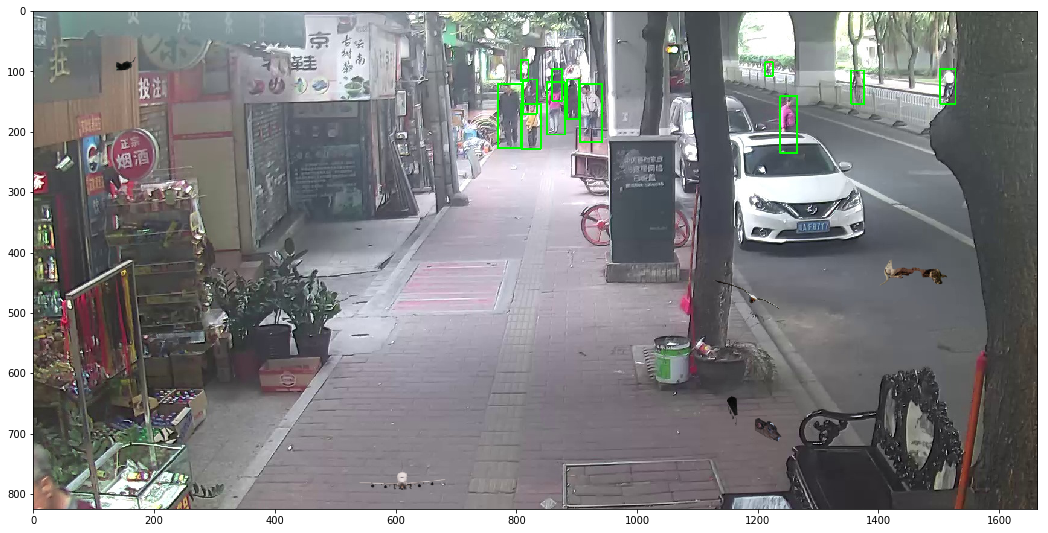

In [56]:
# test and visualize
img_name = "sur00216.jpg"
root_path = "/data/dataset/widerped2019/sur_train/sur_train/"
img_path = os.path.join(root_path,img_name)
original_im = cv2.imread(img_path)
print(original_im.shape)
plt.figure(figsize=(18,18))
original_im=cv2.cvtColor(original_im,cv2.COLOR_BGR2RGB)
img = occlude_with_objects(original_im, occluders, security[img_name])
draw_gt(img, security[img_name])
plt.axis("on")
plt.imshow(img)


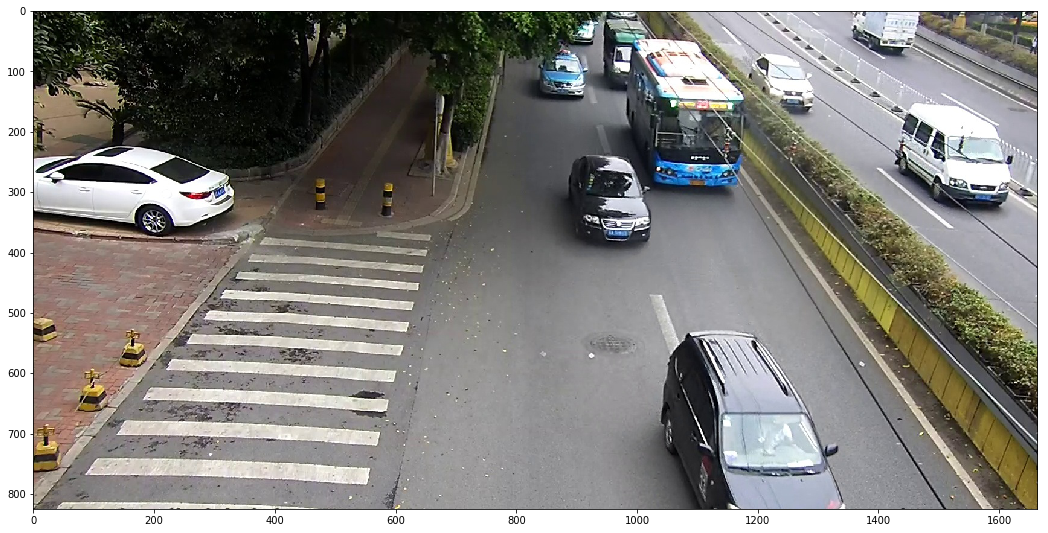

In [118]:
img_name = "sur03801.jpg"
out_path = "/data/dataset/widerped2019/sur_train/sur_train/"

im_path = os.path.join(out_path,img_name)
im = cv2.imread(im_path)
plt.figure(figsize=(18,18))
im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
draw_gt(im, security[img_name])
plt.imshow(im)